In [1]:
import RxInferClientOpenAPI
import h5py
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

In [2]:
class RxInfer:
	def __init__(self, token: str = None):
		self.client = RxInferClientOpenAPI.ApiClient()
		if token:
			self.token = token
		else:
			self.token = RxInferClientOpenAPI.AuthenticationApi(self.client).generate_token().token
			print(f"A new token has been generated: {self.token}")
		self.client.default_headers['Authorization'] = f"Bearer {self.token}"

	def create_model(self, model_name: str, description: str = None):
		self.model_id = RxInferClientOpenAPI.ModelsApi(self.client).create_model({
			"model": model_name,
			"description": description
		}).model_id
		print(f"Model {model_name} has been created with id {self.model_id}")
		return self.model_id
	
	def infer(self, model_id: str = None, data: dict = None, timestamp: str = None, episode_name: str = "default"):
		selected_model_id = model_id if model_id else self.model_id
		if (data is not None)and (data.get("t") is not None)and (timestamp is None):
			timestamp = data.get("t")[0]
		response = RxInferClientOpenAPI.ModelsApi(self.client).run_inference(
			model_id=selected_model_id,
			infer_request={
				"data": data,
				"timestamp": timestamp,
				"episode_name": episode_name
			})
		return response
	
	def plan(self, model_id: str = None, data: dict = None, timestamp: str = None, episode_name: str = "default"):
		selected_model_id = model_id if model_id else self.model_id
		response = RxInferClientOpenAPI.ModelsApi(self.client).run_planning(
			model_id=selected_model_id,
			planning_request={
				"data": data,
				"timestamp": timestamp,
				"episode_name": episode_name
			})
		return response
	
	def act(self, model_id: str = None, data: dict = None, timestamp: str = None, episode_name: str = "default"):
		selected_model_id = model_id if model_id else self.model_id
		response = RxInferClientOpenAPI.ModelsApi(self.client).run_action(
			model_id=selected_model_id,
			action_request={
				"data": data,
				"timestamp": timestamp,
				"episode_name": episode_name
			})
		return response

In [3]:
f = h5py.File("data/simulation.jld2", "r")
time = f["t"][:].tolist()
positions = [f[ref][:].tolist() for ref in f["position"][:]]
velocities = [f[ref][:].tolist() for ref in f["velocity"][:]]
attitudes = [f[ref][:].tolist() for ref in f["attitude"][:]]
angular_velocities = [f[ref][:].tolist() for ref in f["angular_velocity"][:]]
wind_velocities = [f[ref][:].tolist() for ref in f["wind"][:]]
dt = float(f["dt"][...])

In [4]:
def extract_results(results):
    positions = [result["position_mean"] for result in results]
    velocities = [result["velocity_mean"] for result in results]
    attitudes = [result["attitude_mean"] for result in results]
    angular_velocities = [result["angular_velocity_mean"] for result in results]
    wind_velocities = [result["wind_mean"] for result in results]
    return positions, velocities, attitudes, angular_velocities, wind_velocities

In [5]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from dataclasses import dataclass


@dataclass
class DroneParameters:
    """Drone parameters for the simplified quadrotor model."""
    m: float = 0.65  # mass (kg)
    g: float = 9.806  # gravity (m/s^2)
    l: float = 0.232  # arm length (m)
    Jx: float = 7.5e-3  # moment of inertia around x-axis
    Jy: float = 7.5e-3  # moment of inertia around y-axis
    Jz: float = 1.3e-2  # moment of inertia around z-axis
    Kt: float = 0.4  # translational drag coefficient
    Kr: float = 1e-2  # rotational drag coefficient
    CT: float = 0.055  # thrust coefficient
    CQ: float = 0.024  # torque coefficient

def quaternion_to_rotation_matrix(q):
    """Convert quaternion to rotation matrix.
    
    Args:
        q: quaternion [q0, q1, q2, q3] where q0 is the scalar part
        
    Returns:
        3x3 rotation matrix
    """
    q0, q1, q2, q3 = (q /np.linalg.norm(q))
    
    R = np.array([
        [1 - 2*(q2**2 + q3**2), 2*(q1*q2 - q0*q3), 2*(q1*q3 + q0*q2)],
        [2*(q1*q2 + q0*q3), 1 - 2*(q1**2 + q3**2), 2*(q2*q3 - q0*q1)],
        [2*(q1*q3 - q0*q2), 2*(q2*q3 + q0*q1), 1 - 2*(q1**2 + q2**2)]
    ])
    
    return R

def quaternion_derivative(q, omega):
    """Calculate the derivative of a quaternion given angular velocity.
    
    Args:
        q: quaternion [q0, q1, q2, q3]
        omega: angular velocity [ωx, ωy, ωz]
        
    Returns:
        time derivative of quaternion
    """
    q0, q1, q2, q3 = (q /np.linalg.norm(q))
    wx, wy, wz = omega
    
    dq = 0.5 * np.array([
        -q1*wx - q2*wy - q3*wz,
        q0*wx + q3*wy - q2*wz,
        -q3*wx + q0*wy + q1*wz,
        q2*wx - q1*wy + q0*wz
    ])
    
    return dq

def f0_simplified(x2, q, parameters, v_wind=np.zeros(3)):
    """Calculate translational dynamics without control input.
    
    Args:
        x2: linear velocity [vx, vy, vz]
        q: quaternion [q0, q1, q2, q3]
        parameters: drone parameters (DroneParameters object or array)
        v_wind: wind velocity vector [wx, wy, wz]
        
    Returns:
        Translational acceleration without control
    """
    g = parameters.g
    m = parameters.m
    Kt = parameters.Kt
    
    G = np.array([0, 0, g])
    R = quaternion_to_rotation_matrix(q)
    
    return -G - (1/m)*R.dot(Kt*R.T.dot(x2 - v_wind))


def f1_simplified(q, omega, parameters):
    """Calculate rotational dynamics without control input.
    
    Args:
        q: quaternion [q0, q1, q2, q3]
        omega: angular velocity [ωx, ωy, ωz]
        parameters: drone parameters (DroneParameters object or array)
        
    Returns:
        Angular acceleration without control
    """
    Jx = parameters.Jx
    Jy = parameters.Jy
    Jz = parameters.Jz
    Kr = parameters.Kr
    
    J = np.array([
        [Jx, 0, 0],
        [0, Jy, 0],
        [0, 0, Jz]
    ])
    
    return np.linalg.inv(J).dot(np.cross(-omega, J.dot(omega)) - Kr*omega)


def g0_simplified(q, thrust_total, parameters):
    """Calculate control effect on translational dynamics.
    
    Args:
        q: quaternion [q0, q1, q2, q3]
        thrust_total: total thrust
        parameters: drone parameters (DroneParameters object or array)
        
    Returns:
        Control contribution to translational acceleration
    """
    m = parameters.m
    
    R = quaternion_to_rotation_matrix(q)
    thrust_vector = R.dot(np.array([0, 0, thrust_total]))
    
    return thrust_vector / m


def g1_simplified(q, thrusts, parameters):
    """Calculate control effect on rotational dynamics.
    
    Args:
        q: quaternion [q0, q1, q2, q3]
        thrusts: individual motor thrusts [T₁, T₂, T₃, T₄]
        parameters: drone parameters (DroneParameters object or array)
        
    Returns:
        Control contribution to angular acceleration
    """
    l = parameters.l
    Jx = parameters.Jx
    Jy = parameters.Jy
    Jz = parameters.Jz
    CQ = parameters.CQ
    CT = parameters.CT
    
    J = np.array([
        [Jx, 0, 0],
        [0, Jy, 0],
        [0, 0, Jz]
    ])
    
    # Calculate torques from thrusts
    roll_torque = l/np.sqrt(2) * (thrusts[0] - thrusts[1] - thrusts[2] + thrusts[3])
    pitch_torque = l/np.sqrt(2) * (-thrusts[0] - thrusts[1] + thrusts[2] + thrusts[3])
    
    # Yaw torque coefficient
    yaw_coeff = CQ / CT
    yaw_torque = yaw_coeff * (-thrusts[0] + thrusts[1] - thrusts[2] + thrusts[3])
    
    return np.linalg.inv(J).dot(np.array([roll_torque, pitch_torque, yaw_torque]))


def quadrotor_dynamics_simplified(u, t, control_fn, parameters, wind_fn=None):
    """ODE function for simplified quaternion-based quadrotor dynamics.
    
    State vector layout (13 components):
    - u[0:3]: position (x, y, z)
    - u[3:6]: linear velocity (vx, vy, vz)
    - u[6:10]: quaternion (q₀, q₁, q₂, q₃)
    - u[10:13]: angular velocity (ωx, ωy, ωz)
    
    Args:
        u: state vector
        t: time
        control_fn: function that returns control input [T₁, T₂, T₃, T₄] at time t
        parameters: drone parameters (DroneParameters object or array)
        wind_fn: function that returns wind velocity [wx, wy, wz] at time t
        
    Returns:
        state derivatives
    """
    # Extract state components
    pos = u[0:3]
    vel = u[3:6]
    quat = u[6:10]
    omega = u[10:13]
    
    # Normalize quaternion
    quat = quat / np.linalg.norm(quat)
    
    # Get control input (thrusts) for current time
    thrusts = control_fn(t)
    
    # Get wind if provided
    v_wind = wind_fn(t) if wind_fn is not None else np.zeros(3)
    
    # Total thrust for translational dynamics
    total_thrust = np.sum(thrusts)
    
    # Calculate state derivatives
    dpos = vel  # Position derivatives
    dvel = f0_simplified(vel, quat, parameters, v_wind) + g0_simplified(quat, total_thrust, parameters)
    dquat = quaternion_derivative(quat, omega)
    domega = f1_simplified(quat, omega, parameters) + g1_simplified(quat, thrusts, parameters)
    
    # Combine all derivatives
    du = np.concatenate([dpos, dvel, dquat, domega])
    
    return du


def simulate_quadrotor(initial_state, t_span, control_fn, parameters, wind_fn=None):
    """Simulate quadrotor dynamics using odeint.
    
    Args:
        initial_state: initial state vector (13 components)
        t_span: time points for simulation
        control_fn: function that returns control input at time t
        parameters: drone parameters
        wind_fn: function that returns wind velocity at time t
        
    Returns:
        states: array of state vectors at each time point
    """
    # Simulate using odeint
    states = odeint(
        quadrotor_dynamics_simplified, 
        initial_state, 
        t_span, 
        args=(control_fn, parameters, wind_fn)
    )
    
    # Normalize quaternions in the solution
    for i in range(len(states)):
        states[i, 6:10] = states[i, 6:10] / np.linalg.norm(states[i, 6:10])
    
    return states

In [6]:
class DroneEnvironment:

	def __init__(self, initial_state=None, params=None, wind_fn=None, dt=0.001):
		if initial_state is None:
			initial_state = np.array([
				0.0, 0.0, 0.0,          # position
				0.0, 0.0, 0.0,          # velocity
				1.0, 0.0, 0.0, 0.0,     # quaternion (identity rotation)
				0.0, 0.0, 0.0           # angular velocity
			])
		if params is None:
			params = DroneParameters()
		if wind_fn is None:
			wind_fn = lambda t: np.zeros(3)

		self.state = initial_state
		self.params = params
		self.wind_fn = wind_fn

		self.dt = dt

	def act(self, control):
		control_fn = self.to_control_fn(control)
		self.state = simulate_quadrotor(self.state, np.array([0, self.dt]), control_fn, self.params, self.wind_fn)[1]
		return self.state[0:3]
	
	def to_control_fn(self, plan_response):
		control_fn = lambda t: plan_response.results["planned_control"][int(t/self.dt)]
		return control_fn

In [7]:
def plot_positions(positions, inferred_positions):
    plt.plot(time, inferred_positions, label=[f"inferred {i} position" for i in ["x", "y", "z"]])
    plt.plot(time, positions, label=[f"true {i} position" for i in ["x", "y", "z"]], linestyle="dotted", color="black")
    plt.grid()
    plt.legend()
    plt.show()
    
def plot_normalized_velocities(velocities, wind_velocities, inferred_velocities, inferred_wind_velocities):
    plt.plot(time, np.array(inferred_velocities), label=[f"inferred {i} velocity" for i in ["x", "y", "z"]])
    plt.plot(time, np.array(velocities), label=[f"true {i} velocity" for i in ["x", "y", "z"]], linestyle="dotted", color="black")
    plt.grid()
    plt.legend()
    plt.show()
    
def plot_planned_path(inferred_position, plan_response, goal_position):
	ax = plt.figure().add_subplot(projection='3d')
	ax.scatter([inferred_position[0]], [inferred_position[1]], [inferred_position[2]], label="inferred position")
	ax.scatter([goal_position[0]], [goal_position[1]], [goal_position[2]], label="goal position")
	ax.plot(
		[x[0] for x in plan_response.results["planned_state"]],
		[x[1] for x in plan_response.results["planned_state"]],
		[x[2] for x in plan_response.results["planned_state"]],
		label="planned path",
		linestyle="dashed"
	)
	ax.legend()

In [8]:
client = RxInfer()

A new token has been generated: a6a71c2e-f39a-45fc-a517-2df9c97d3060


In [9]:
client.create_model("Drone-v1", "Simplified drone model");

Model Drone-v1 has been created with id 83249322-3018-4b6b-8d6a-ec03f50ac24e


In [10]:
drone_environment = DroneEnvironment()

In [11]:
infer_response = client.infer(
    data={
        "t": [time[0]],
        "y": [positions[0]],
        "control": [0, 0, 0, 0]
	}
)

In [12]:
time[0]

0.0

In [13]:
type(positions[0])

list

In [14]:
inferred_state = infer_response.results["state_mean"]

In [15]:
plan_response = client.plan(
    data={
        "goal_position": [2, 1, 0.5],
	}
)

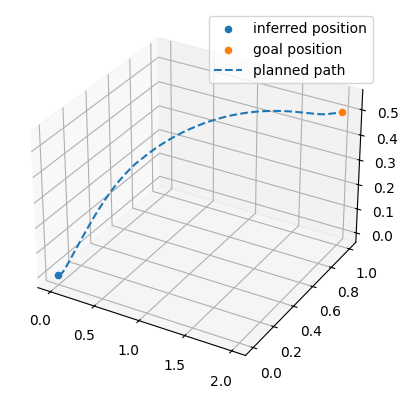

In [16]:
plot_planned_path(inferred_state, plan_response, [2, 1, 0.5])

In [17]:
positions = []
inferred_position = [0,0,0]
t = 0
control = [0,0,0,0]
drone_environment = DroneEnvironment()

for k in range(1000):

	# update state
	infer_response = client.infer(
		data={
			"t": [t],
			"y": [inferred_position],
			"control": control
		}
	)
	inferred_position = infer_response.results["state_mean"][:3]

	# plan trajectory
	plan_response = client.plan(
		data={
			"goal_position": [2, 1, 0.5],
		}
	)

	# perform action
	control = plan_response.results["planned_control"][0]
	observed_position = drone_environment.act(plan_response)
	positions.append(observed_position)

	t = t + drone_environment.dt


BadRequestException: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Content-Type': 'application/json', 'Access-Control-Allow-Origin': '*', 'Access-Control-Allow-Methods': 'GET, POST, PUT, DELETE, OPTIONS', 'Access-Control-Allow-Headers': 'Content-Type, Authorization', 'Transfer-Encoding': 'chunked'})
HTTP response body: {"error":"Bad Request","message":"Unable to run inference due to internal error"}


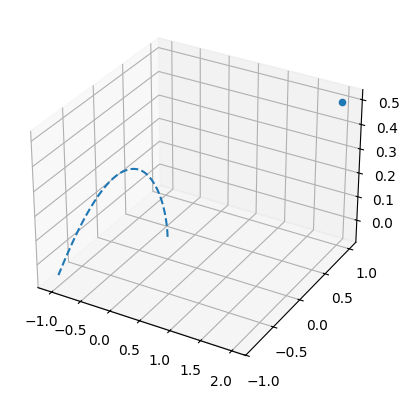

In [18]:
ax = plt.figure().add_subplot(projection='3d')
ax.scatter([2], [1], [0.5], label="goal position")
ax.plot(
	[x[0] for x in positions],
	[x[1] for x in positions],
	[x[2] for x in positions],
	label="planned path",
	linestyle="dashed"
)